# Introduction

In this notebook we will be exploring parking tickets issued for infractions by the city of toronto from 2008 to 2020. The data is openly available in their data portal at https://open.toronto.ca/dataset/parking-tickets/ . In this particular notebook we will be exploring and trying to interpret the data.

# Setting things up

First let's take care of imports and global variables that we will be using later

In [1]:
import calendar
import csv
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

In [2]:
# The folder containing parking csvs
tickets_folder = "data/tickets/csv"
# File to export combined csv file to
combined_tickets = "data/tickets/combined.csv" 
# File to export top 20 infractions by count
top_20_count_file = "data/tickets/top_20_count.csv" 
# File to export top 20 infractions by fine amount
top_20_fine_file = "data/tickets/top_20_fine.csv" 

# Reading the tickets

Now, we need to read data from all the csv files that contain the parking tickets information.

In [3]:
# read ticket data
# first get list of all csv files in the tickets folder
csv_files = glob.glob(f"{tickets_folder}/*.csv")

# create an empty list to read and store parsed data from each csv
parsed_csvs = []
problematic_files = []

# now go through each csv file in the folder
for csv_file in csv_files:
    print(f"Reading data from: {csv_file}")
    # try read the csv file into a dataframe using default parameters (fast)
    try:
        df = pd.read_csv(csv_file, index_col=None, header=0)
        parsed_csvs.append(df)
    except Exception as e:
        # If we get an error the default way, it means that there are fields that
        # have double quotes for the comma within the fields
        print(f"Could not read {csv_file} with default parameters!")
        problematic_files.append(csv_file)

Reading data from: data/tickets/csv/Parking_Tags_Data_2019.008.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2012.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2015_2.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2015_3.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2017_1.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2013.csv
Could not read data/tickets/csv/Parking_Tags_Data_2013.csv with default parameters!
Reading data from: data/tickets/csv/Parking_Tags_data_2011.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2017_3.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2015_1.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_2017_2.csv
Reading data from: data/tickets/csv/Parking_Tags_data_2010.csv
Could not read data/tickets/csv/Parking_Tags_data_2010.csv with default parameters!
Reading data from: data/tickets/csv/Parking_Tags_Data_2020.004.csv
Reading data from: data/tickets/csv/Parking_Tags_Data_20

**Note:**

As we can see there are some files that we have issues parsing. Therefore, we will specifically handle them in ways where we don't end up loosing a lot of data 

In [4]:
# These four files need to be dealt with in their own way since they have different issues.

# once again, we create empty csv to store list of data frames for the files
problematic_file_csvs = []

# First lets read the data for 2013 (this one has issues with odd number of quotes)
# This requires us to use python engine to better handle the data error.
prob_file = "data/tickets/csv/Parking_Tags_Data_2013.csv"
print(f"Reading {prob_file} using additional parameters.")
df = pd.read_csv(prob_file, 
                 index_col=None, 
                 header=0,
                 quotechar="\"", 
                 error_bad_lines=False,
                 engine="python"
                )
problematic_file_csvs.append(df)

# Next lets read the data for 2008 and 2010 as they have same issues
# i.e. utf-16 encoding
for prob_file in ["data/tickets/csv/Parking_Tags_Data_2008.csv",\
                  "data/tickets/csv/Parking_Tags_Data_2010.csv"]:
    print(f"Reading {prob_file} using additional parameters.")
    df = pd.read_csv(prob_file, 
                     index_col=None, 
                     header=0,
                     encoding = "utf-16",
                     quotechar="\"",
                     error_bad_lines=False,
                    )
    problematic_file_csvs.append(df)

# Finally lets read for 2009. This also has issues with quotes/comma in data 
# but it doesn't have issues with odd number of quotes so we can use default
# c compiler to read the data
prob_file = "data/tickets/csv/Parking_Tags_Data_2009.csv"
print(f"Reading {prob_file} using additional parameters.")
df = pd.read_csv(prob_file, 
                 index_col=None, 
                 header=0,
                 quotechar="\"", 
                 error_bad_lines=False,
                )
problematic_file_csvs.append(df)

Reading data/tickets/csv/Parking_Tags_Data_2013.csv using additional parameters.


Skipping line 2351360: field larger than field limit (131072)


Reading data/tickets/csv/Parking_Tags_Data_2008.csv using additional parameters.


b'Skipping line 181770: expected 11 fields, saw 12\n'


Reading data/tickets/csv/Parking_Tags_Data_2010.csv using additional parameters.


b'Skipping line 1075521: expected 11 fields, saw 14\n'
b'Skipping line 1413505: expected 11 fields, saw 16\n'


Reading data/tickets/csv/Parking_Tags_Data_2009.csv using additional parameters.


b'Skipping line 170864: expected 11 fields, saw 12\n'


**Note:**

We have successfully read all the csv files with this while loosing minimal amount of data.

In [5]:
# We can now convert all the parsed data into a single dataframe
all_tickets = pd.concat(parsed_csvs + problematic_file_csvs, axis=0, ignore_index=True)

print("Our dataframe has the size of : ", all_tickets.shape)

# inspect data frame
all_tickets.head()

Our dataframe has the size of :  (31044191, 11)


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***51471,20191124,207.0,PARK MACHINE-REQD FEE NOT PAID,30,2011.0,NR,548 DANFORTH AVE,NaN,NaN,ON
1,***61170,20191124,207.0,PARK MACHINE-REQD FEE NOT PAID,30,2011.0,NR,510 COLLEGE ST,NaN,NaN,ON
2,***92224,20191124,207.0,PARK MACHINE-REQD FEE NOT PAID,30,2011.0,NR,541 MOUNT PLEASANT RD,NaN,NaN,ON
3,***76780,20191124,29.0,PARK PROHIBITED TIME NO PERMIT,30,2012.0,E/S,PRINCESS ST,S/O,FRONT ST E,ON
4,***39600,20191124,2.0,PARK - LONGER THAN 3 HOURS,30,2012.0,NR,32 FIELDWOOD DR,NaN,NaN,ON


In [6]:
# Now, let's explored the parsed data types
all_tickets.dtypes

tag_number_masked          object
date_of_infraction          int64
infraction_code           float64
infraction_description     object
set_fine_amount             int64
time_of_infraction        float64
location1                  object
location2                  object
location3                  object
location4                  object
province                   object
dtype: object

**Data Description**
- tag_number_masked : contains the tag_number (with first three digits masked)
- date_of_infraction : date of infraction in YYYYMMDD format
- infraction_code : Infration code
- infraction_description : Short description of infraction
- set_fine_amount : Fine amount
- time_of_infraction : Time of infraction in HHMM format (24-hr)
- location1 : Code for Proximity of location 2
- location2 : Street Address (optionsl)
- location3 : Code for proximity of location 3
- location4 : Streett Address (optional)
- province : Province or statte code of vehicle license plate

Most of the data is string data and interpreted as such, but one more thing that we need to do is clean the string data by trimming whitespaces

In [7]:
# Select all the string columns
strings = all_tickets.select_dtypes(['object'])
# Trim the data
all_tickets[strings.columns] = strings.apply(lambda x: x.str.strip())

Let's export all these valid data to a single file so that all the data can be accessed easily when we need to.

In [8]:
# save this df in a single csv to make subsequent reads easier
all_tickets.to_csv(combined_tickets)

Since the data for *infraction_description* and *province* are categorical data, we can convert the columns to a category type to make analyses faster

In [9]:
# create a copy of all_ticket object so that it's easier to go back if we make a mistake
all_tickets_fixed = all_tickets.copy()
# change the types of columns to category
all_tickets_fixed["infraction_description"] = all_tickets_fixed["infraction_description"].astype("category")
all_tickets_fixed["province"] = all_tickets_fixed["province"].astype("category")

In [10]:
# looking at a summary of our data
all_tickets_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31044191 entries, 0 to 31044190
Data columns (total 11 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   tag_number_masked       object  
 1   date_of_infraction      int64   
 2   infraction_code         float64 
 3   infraction_description  category
 4   set_fine_amount         int64   
 5   time_of_infraction      float64 
 6   location1               object  
 7   location2               object  
 8   location3               object  
 9   location4               object  
 10  province                category
dtypes: category(2), float64(2), int64(2), object(5)
memory usage: 2.2+ GB


# Exploring the data
After reading and cleaning the raw data, we can now explore the data in depth and try to interpret them.

*DISCLAIMER: While it would be a good idea to use **infraction_code** as category fields to inspect the data, I went with the more readable **infraction_description** because of my limited understanding of the data and it reads like a categorical data*

In [11]:
# checking the summary of specific columns 
all_tickets_fixed.describe(include='category')

,infraction_description,province
count,31044191,31044172
unique,586,74
top,PARK PROHIBITED TIME NO PERMIT,ON
freq,4748939,29711545


Looking at the categorical columns, we can say that there are 586 types of infractions with top infraction being *PARK PROHIBITED TIME NO PERMIT*. Similarly we have 74 unique entries for province (or state) with top being *ON*

In [12]:
# exploring null data and missing values
all_tickets_fixed.isnull().sum()

tag_number_masked                0
date_of_infraction               0
infraction_code                  2
infraction_description           0
set_fine_amount                  0
time_of_infraction           23867
location1                  2529336
location2                     9177
location3                 29359131
location4                 29349744
province                        19
dtype: int64

There is a number of columns null but most of them are on location fields which are optional.

**Finding out top 20 infractions by occurrence**

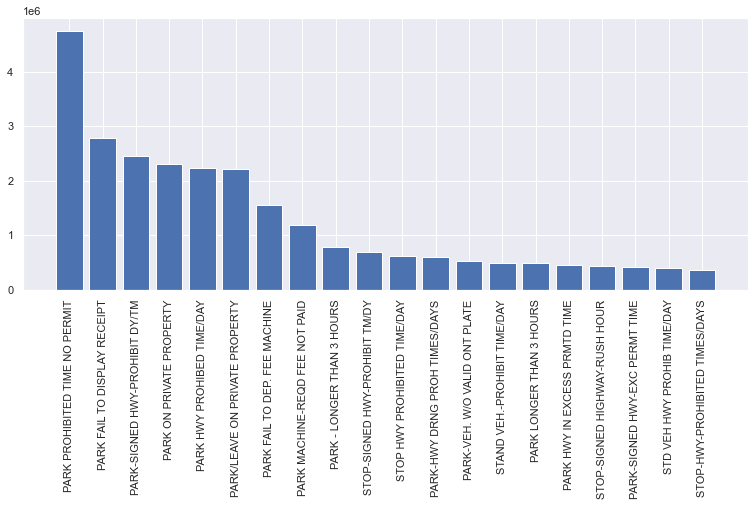

In [13]:
# get top 20 infractions by frequency
top_20_count = all_tickets_fixed["infraction_description"].value_counts()[:20].reset_index()
top_20_count.columns = ["infraction_description", "count"]
# plot them into a bar chart
plt.figure(figsize=(13,5))
plt.bar(top_20_count["infraction_description"],top_20_count["count"])
plt.xticks(rotation="vertical")
plt.show()

Here we can see that, *PROHIBITED TIME NO PERMIT* is by far the most common occurrence with around two times more frequent as the second highest infraction by frequency wich is *PARK FAIL TO DISPLAY RECEIPT*. Furthermore, across the top 20 infrations, parking violations with time/day restrictions. This can mean that the message regarding parking/stopping resttrictions based on time/day might not clear to drivers

**Finding out top 20 infractions by fine**

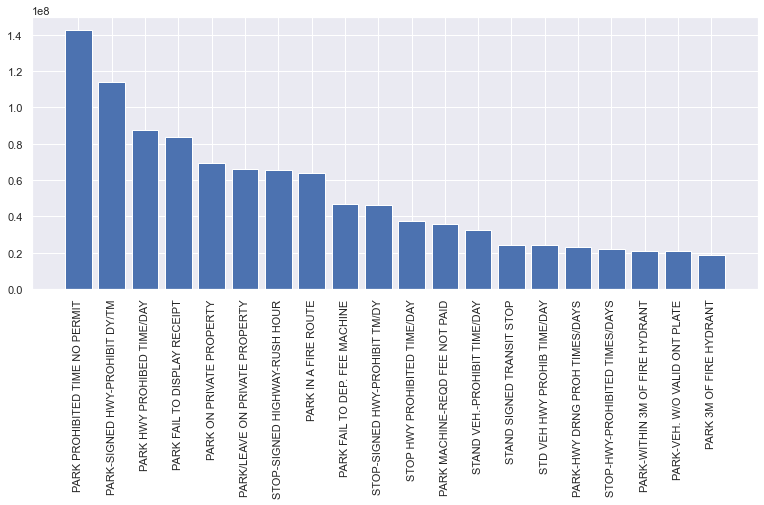

In [14]:
# group by infraction_description and get sum of fines in each infraction
top_20_fines = all_tickets_fixed[["infraction_description","set_fine_amount"]]\
                    .groupby("infraction_description")\
                    .sum()\
                    .sort_values(by=['set_fine_amount'], ascending=False)[0:20]\
                    .reset_index()
# plot into a bar chart
plt.figure(figsize=(13,5))
plt.bar(top_20_fines["infraction_description"],top_20_fines["set_fine_amount"])
plt.xticks(rotation="vertical")
plt.show()

While for the occurrences, the top infraction was a lot higher than the second one, it is different in terms of revenue generatted. The top revenue generation infraction is still *PARK PROHIBITED TIME NO PERMIT* because of its's volume but the second in this case is *PARK-SIGNED HWY-PROHIBIT DY/TM* which was third highest in terms of occurrence. The case is similar for other highway related violations. In the same manner, violations related to fire safety generate more in fines while not being as frequent.

**Finding out the total revenue generated so far**

In [15]:
# Total revenue generated from all tickets
total_revenue = all_tickets_fixed["set_fine_amount"].sum()
print(f"The total revenue generated from all tickets from 2008 to 2020 was ${total_revenue}")

The total revenue generated from all tickets from 2008 to 2020 was $1362646805


**Inspecting infractions by year**

In [16]:
# once again, we copy a subset of the dataframe to keep the main object clean
infraction_dates = all_tickets_fixed[["date_of_infraction"]].copy()

AxesSubplot(0.125,0.125;0.775x0.755)


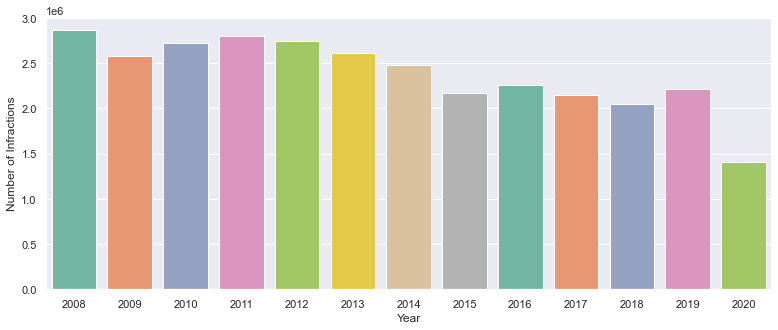

In [17]:
# get year of infraction
infraction_dates["year"] = pd.to_datetime(infraction_dates["date_of_infraction"],
                                                 format="%Y%m%d"
                                                ).dt.year
# plot the distribution in a bar chart
plt.figure(figsize=(13,5))
count_plot = sns.countplot(
    x=infraction_dates["year"], 
    palette="Set2",
)
count_plot.set_xlabel("Year")
count_plot.set_ylabel("Number of Infractions")
print(count_plot)

The charts clearly show that there is an overall downward trend of violations by year. While 2020 is an anomaly because of lockdown restrictions due to COVID-19. It can be seen that the number of infractoins has decreased by a substantial amount in the past decade. One concerning thing is that the number of infractions in 2019 increased from 2018 to catch that from 2015 and get close to 2016. It is uncertain whether this is a shift in trend or a small spike like in 2016 because we can not rely on 2020 data to make that interpretation.

**Inspecting infractions by month**

AxesSubplot(0.125,0.125;0.775x0.755)


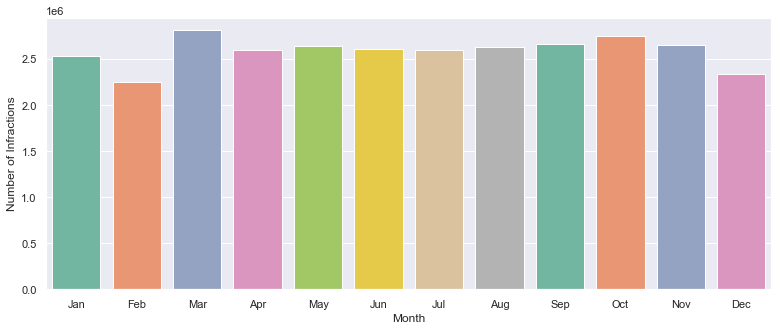

In [18]:
# get month of infraction
infraction_dates["month"] = pd.to_datetime(infraction_dates["date_of_infraction"],
                                                 format="%Y%m%d"
                                                ).dt.month
# change the month number to month code
infraction_dates["month_name"] = infraction_dates["month"].apply(lambda x: calendar.month_abbr[x])
infraction_dates["month_name"] = infraction_dates["month_name"].astype("category")

# plot the distribution by month
plt.figure(figsize=(13,5))
count_plot = sns.countplot(
    x=infraction_dates["month_name"], 
    palette="Set2",
    order= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)
count_plot.set_xlabel("Month")
count_plot.set_ylabel("Number of Infractions")
print(count_plot)

From the chart above, there doesn't seem to be any obvious difference in infractions based on months except from Dec and Feb. This could be due to people taking vacations and as a result commuting less in Dec while driving less due to snow in Feb.

**Inspecting infractions by day of week**

AxesSubplot(0.125,0.125;0.775x0.755)


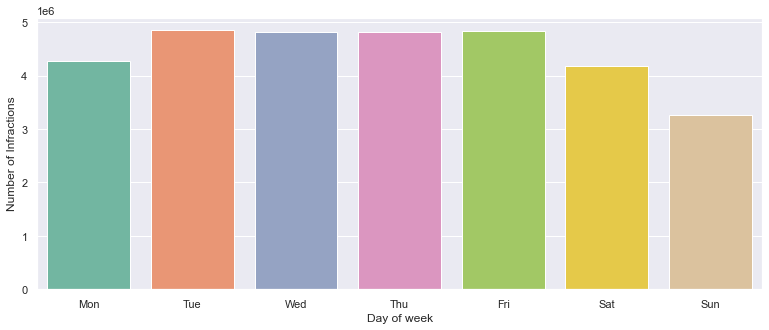

In [19]:
# get the day of week
infraction_dates["day_of_week"] = pd.to_datetime(infraction_dates["date_of_infraction"],
                                                 format="%Y%m%d"
                                                ).dt.dayofweek.astype("category")

# plot the distribution by day of month in a bar chart
plt.figure(figsize=(13,5))
count_plot = sns.countplot(
    x=infraction_dates["day_of_week"], 
    palette="Set2",
)
months=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
count_plot.set_xticklabels(months)
count_plot.set_xlabel("Day of week")
count_plot.set_ylabel("Number of Infractions")
print(count_plot)

The day of week chart tell similar story as above with Sunday having significantly less number of tickets issued. A dropoff on saturday was also expected but this might be attributed to the fact that some business are open on limitted hours on saturday while remain closed on sunday but it might also be a more behavorial pattern of the public which needs to be studied further.

**Inspecting infractions by seasons**

In this case we will consider 4 seasons in canada defined as follows
- canadian seasons defined in this notebook as follows
- spring - march to may
- summer - june to aug
- fall - september to november
- winter - december to february

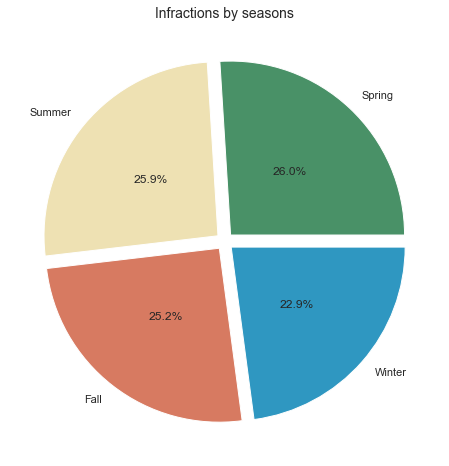

In [20]:
# define array for seasons in which a month belongs
seasons = [4,4,1,1,1,2,2,2,3,3,3,4]
# create a dictionary map of months to seasons
months_seasons = dict(zip(range(1,13), seasons))

# get seasons in a month
infraction_dates["season"] = infraction_dates["month"].map(months_seasons)

# plot the ratio of infractions by season in a piechart
plt.subplots(figsize=[8,8])
seasons = ["Spring","Summer","Fall","Winter"]
plt.pie(x=infraction_dates["season"].value_counts(), 
        autopct="%.1f%%",
        colors=["#499167","#EEE1B3","#D77A61","#2F97C1"],
        explode=[0.05]*4, 
        labels=seasons, 
        pctdistance=0.5)
plt.title("Infractions by seasons", fontsize=14);

So far, the charts have been consistent in sayingthat less travel equates to less parking tickets being handed out. Once again, this is supported by the seasonal chart where winter season shows less tickets tthan the otther three which have similar ratio.

# A way forward
There are multiple things we can do to investigate this further. The first think that we can do is explore the distribution of data by hours and see if there is a time of day where most infractions occur. Another thing that can be done is check the infraction distribution within each year and see if there has been any change throughout the years in certain infractions. There might be some infraction that has become more common while others that have become less common. This means we would need to shift focus to the issues that are graining traction to address them.